In [3]:
import os

os.chdir('/opt/ml/P-Stage/1-STAGE/')

In [4]:
""" 모델의 다양한 성능을 측정  """

import os
from PIL import Image

import wandb
import torch
import numpy as np
import pandas as pd
import torch.nn as nn

import matplotlib.pyplot as plt

from train import evaluate, get_lossfn
from config import get_args
from prepare import get_dataloader, get_transforms
from metrics import (
    change_2d_to_1d,
    FocalLoss,
)


def eval_class(mi, gi, ai):
    return 6 * mi + 3 * gi + ai


def _log_f1_and_acc_scores(args, summary_table, labels, outputs):
    args.train_key = key
    _, labels, outputs = evaluate(args, model, loss_fn, data_loader)

    # class 별 f1_score를 계산해야함.

    f1_score = cal_metrics(outputs, labels)
    acc_score = cal_accuracy(outputs, labels)

    summary_table.loc[key] = [f1_score, acc_score]

    return labels, outputs

def _log_confusion_matrix(args, labels, outputs):
    return 

def _log_():
    return


def log_scores(args, keys, models):
    """ loss_fn: use same model """

    label_list, output_list = [], []
    loss_fn = get_lossfn(args).to(args.device)

    summary_table = pd.DataFrame(columns=["f1_score", "accuracy"])

    for model, key in zip(models, keys):
        args.train_key = key
        _, valid_dataloader = get_dataloader(args)
        
        labels, outputs = evaluate(args, model, loss_fn, valid_dataloader)

        _log_f1_and_acc_scores(args, summary_table, labels, outputs)
        _log_confusion_matrix(args, labels, outputs)


        label_list.append(labels.detach().cpu().numpy())
        output_list.append(outputs.detach().cpu().numpy())

    return summary_table, label_list, output_list


def load_models(args):
    try:
        age_model = torch.load(args.age_model).to(args.device)
        gender_model = torch.load(args.gender_model).to(args.device)
        mask_model = torch.load(args.mask_model).to(args.device)

        age_model.eval()
        gender_model.eval()
        mask_model.eval()
    except Exception as e:
        raise e
    
    return [mask_model, gender_model, age_model]  # 순서 중요


def main(args):
    wandb.init(project="p-stage-1", reinit=True)
    wandb.config.update(args)
    wandb.run.name = f"predict-{wandb.run.name}"

    print("".join([f"{k:<15} : {v}\n" for k, v in sorted(wandb.config.items(), key=len)]))

    models = load_models(args)
    keys = ["mask", "gender", "age"]

    # mga: mask, gender, age (sequence)
    summary_table, mga_label_lists, mga_output_lists = log_scores(
        args, summary_table, keys, models
    )

    labels, outputs = [], []

    for (mi, gi, ai) in zip(*mga_label_lists):
        labels.append(eval_class(mi, gi, ai))

    for (mi, gi, ai) in zip(*mga_output_lists):
        outputs.append(eval_class(mi, gi, ai))

    acc = cal_accuracy(torch.tensor(labels), torch.tensor(outputs))
    table = wandb.Table(dataframe=summary_table, rows=keys)

    wandb.log({"Result": table, "valid_accuracy": acc})

In [5]:
args = get_args()
args.device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
models = load_models(args)
keys = ['mask', 'gender', 'age']

In [7]:
args.test = True
args.train_key = "mask"

loss_fn = get_lossfn(args)
_, dataloader = get_dataloader(args)
_, labels, outputs = evaluate(args, models[0], loss_fn, dataloader)

In [8]:
labels, outputs = labels.detach().cpu().numpy().astype(np.int), outputs.detach().cpu().numpy().astype(np.int)

In [9]:
class_index = np.where(labels == 2)

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [11]:
from sklearn.metrics import precision_recall_curve

In [9]:
accuracy_score(labels[class_index], outputs[class_index])

0.9977777777777778

In [10]:
f1_score(labels[class_index], outputs[class_index], average='macro')

0.3329625509825732

In [11]:
precision_score(labels[class_index], outputs[class_index], average='macro')

0.3333333333333333

In [12]:
recall_score(labels[class_index], outputs[class_index], average='macro')

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3325925925925926

In [13]:
labels[class_index], outputs[class_index]

(array([2, 2, 2, ..., 2, 2, 2]), array([2, 2, 2, ..., 2, 2, 2]))

In [14]:
labels, outputs

(array([0, 2, 0, ..., 1, 0, 0]), array([0, 2, 0, ..., 1, 0, 0]))

## PipeLine

In [15]:
from prepare import get_classes

import warnings
warnings.filterwarnings('always')

In [16]:
summary_table = pd.DataFrame([])

In [19]:
args.test = True

for model, key in zip(models, keys):
    args.train_key = key
    _, dataloader = get_dataloader(args)
    _, labels, outputs = evaluate(args, model, loss_fn, dataloader)
    labels, outputs = labels.detach().cpu().numpy(), outputs.detach().cpu().numpy()
    classes = get_classes(args)
        
    for class_idx in range(len(classes)):
        fancy_idx = np.where(labels == class_idx)
        f1 = f1_score(labels[fancy_idx], outputs[fancy_idx], average='macro')
        pr = precision_score(labels[fancy_idx], outputs[fancy_idx], average='macro')
        re = recall_score(labels[fancy_idx], outputs[fancy_idx], average='macro')
        acc = accuracy_score(labels[fancy_idx], outputs[fancy_idx])
        
        summary_table.loc[key, f"{class_idx} f1"] = f1
        summary_table.loc[key, f"{class_idx} pr"] = pr
        summary_table.loc[key, f"{class_idx} re"] = re
        summary_table.loc[key, f"{class_idx} acc"] = acc

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1529: DeprecationWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn("This class has been deprecated. Please use CoarseDropout", DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1529: DeprecationWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn("This class has been deprecated. Please use CoarseDropout", DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. U

In [20]:
summary_table

,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc,2 f1,2 pr,2 re,2 acc
mask,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
gender,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
age,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
s_table = summary_table.fillna(0)
# s_table = s_table.applymap(lambda x: "{:,.1f}%".format(x*100))
s_table

,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc,2 f1,2 pr,2 re,2 acc
mask,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
gender,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
age,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
list(s_table)

['0 f1',
 '0 pr',
 '0 re',
 '0 acc',
 '1 f1',
 '1 pr',
 '1 re',
 '1 acc',
 '2 f1',
 '2 pr',
 '2 re',
 '2 acc']

In [31]:
s_table.to_numpy()

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

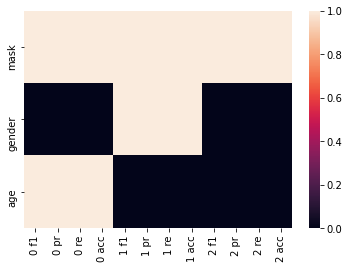

In [27]:
import seaborn as sns

sns.heatmap(s_table)

In [ ]:
summary_table = summary_table.fillna(0)
summary_table = summary_table.applymap(lambda x: "{:,.2f}%".format(x*100))
s_table = summary_table.style.background_gradient(cmap=cm)

In [ ]:
s_table

In [ ]:
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)
s_table = s_table.style.format("{:,.2%}")
s_table = summary_table.style.background_gradient(cmap=cm)
s_table

In [ ]:
s_table

In [ ]:
s = summary_table.applymap(lambda x: "{:,.2f}".format(x))
s

In [ ]:
s.style.format("{:.2%}")

In [ ]:
labels, outputs.shape

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cf_m = confusion_matrix(labels, outputs)
cf_m

In [ ]:
sample_classes = get_classes(args.train_key)
sample_classes

In [ ]:
ax.set_xtick

In [ ]:
def plot_confusion_matrix(matrix):
    row_sums = matrix.sum(axis=1, keepdims=True)
    matrix = matrix / row_sums
    np.fill_diagonal(matrix, 0)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap=plt.cm.gray)
    ax.set_title("GD")
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])
    ax.set_xticklabels(sample_classes)
    ax.set_yticklabels(sample_classes)

In [ ]:
plot_confusion_matrix(cf_m)

In [29]:
args.test = True

images, labels = next(iter(dataloader))
outputs = models[0](images.cuda())

images = images.detach().cpu().numpy()
labels = labels.detach().cpu().numpy()
outputs = outputs.detach().cpu().numpy()
images.shape, labels.shape, outputs.shape

((64, 3, 224, 224), (64,), (64, 3))

In [ ]:
classes

In [32]:
outputs = np.argmax(outputs, 1)
outputs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
labels

In [ ]:
import seaborn as sns

cf_m = confusion_matrix(labels, outputs)
plot_confusion_matrix(cf_m)

In [ ]:
plt.ylabel('True label')
plt.xlabel('Predicted label')
sns.heatmap(cf_m, annot=True, cmap='gray', xticklabels=classes, yticklabels=classes,
           cbar=False)

In [ ]:
import copy
import itertools

cm = confusion_matrix(labels, outputs)

def plot_confusion_matrix(cm, cmap=plt.cm.Oranges):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
    fig.suptitle('Confusion Matrix', fontsize=16)
    
    axes[0].imshow(cm, interpolation='nearest', cmap=cmap)
    
    axes[0].set_xticks(range(len(classes)))
    axes[0].set_yticks(range(len(classes)))
    axes[0].set_xticklabels(classes)
    axes[0].set_yticklabels(classes)
    axes[0].set_ylabel('True label')
    axes[0].set_xlabel('Predicted label')
    
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axes[0].text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    np.fill_diagonal(cm, 0)
    axes[1].imshow(cm, interpolation='nearest', cmap=cmap)
    
    axes[1].set_xticks(range(len(classes)))
    axes[1].set_xticklabels(classes)
    axes[1].set_yticks([])
    axes[1].set_xlabel('Predicted label')
    
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axes[1].text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
plot_confusion_matrix(cm)

## Plot Images

In [30]:
MEAN = np.array([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
STD = np.array([0.229, 0.224, 0.225]).reshape(-1, 1, 1)

images = np.clip((images * STD) + MEAN, 0, 1)
images = images.transpose(0, 2, 3, 1)
images.shape

(64, 224, 224, 3)

In [33]:
images10 = images[(labels == 1) & (outputs == 0)]
# images10 = images[()]

In [34]:
from predict import predict

ImportError: cannot import name 'predict' from 'predict' (/opt/ml/P-Stage/1-STAGE/predict.py)

In [43]:
def _log_confusion_matrix_by_images(args, ax, instances, images_per_row=10):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    size = args.image_size
    images_per_row = min(len(instances), images_per_row)
    images = [instance for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1 
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty, 3)))                                                                                                

    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))

    image = np.concatenate(row_images, axis=0)
    ax.imshow(image)

In [37]:
def plot_peoples(instances, images_per_row=10, **options):
    size=224
    image_per_row = min(len(instances), images_per_row)
    images = [instance for instance in instances]    
    n_rows = (len(instances) - 1) // image_per_row + 1
    row_images = []
    n_empty = n_rows * image_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty, 3)))

    for row in range(n_rows):
        rimages = images[row * image_per_row: (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
        
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, **options)
    plt.axis("off")

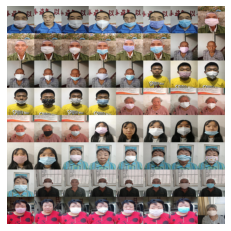

In [38]:
plot_peoples(images, images_per_row=8)

In [39]:
images00 = images[(labels == 0) & (outputs == 0)]
images01 = images[(labels == 0) & (outputs == 1)]
images02 = images[(labels == 0) & (outputs == 2)]
images10 = images[(labels == 1) & (outputs == 0)]
images11 = images[(labels == 1) & (outputs == 1)]
images12 = images[(labels == 1) & (outputs == 2)]
images20 = images[(labels == 2) & (outputs == 0)]
images21 = images[(labels == 2) & (outputs == 1)]
images22 = images[(labels == 2) & (outputs == 2)]

In [40]:
plt.figure(figsize=(8,8))
try:
plt.subplot(331); plot_peoples(images00[:4], images_per_row=2)
plt.subplot(332); plot_peoples(images01[:4], images_per_row=2)
plt.subplot(333); plot_peoples(images02[:4], images_per_row=2)
plt.subplot(334); plot_peoples(images10[:4], images_per_row=2)
plt.subplot(335); plot_peoples(images11[:4], images_per_row=2)
plt.subplot(336); plot_peoples(images12[:4], images_per_row=2)
plt.subplot(337); plot_peoples(images20[:4], images_per_row=2)
plt.subplot(338); plot_peoples(images21[:4], images_per_row=2)
plt.subplot(339); plot_peoples(images22[:4], images_per_row=2)

IndentationError: expected an indented block (<ipython-input-40-bf6c25cb5aa0>, line 3)

integer division or modulo by zero
integer division or modulo by zero
integer division or modulo by zero
integer division or modulo by zero
integer division or modulo by zero
integer division or modulo by zero


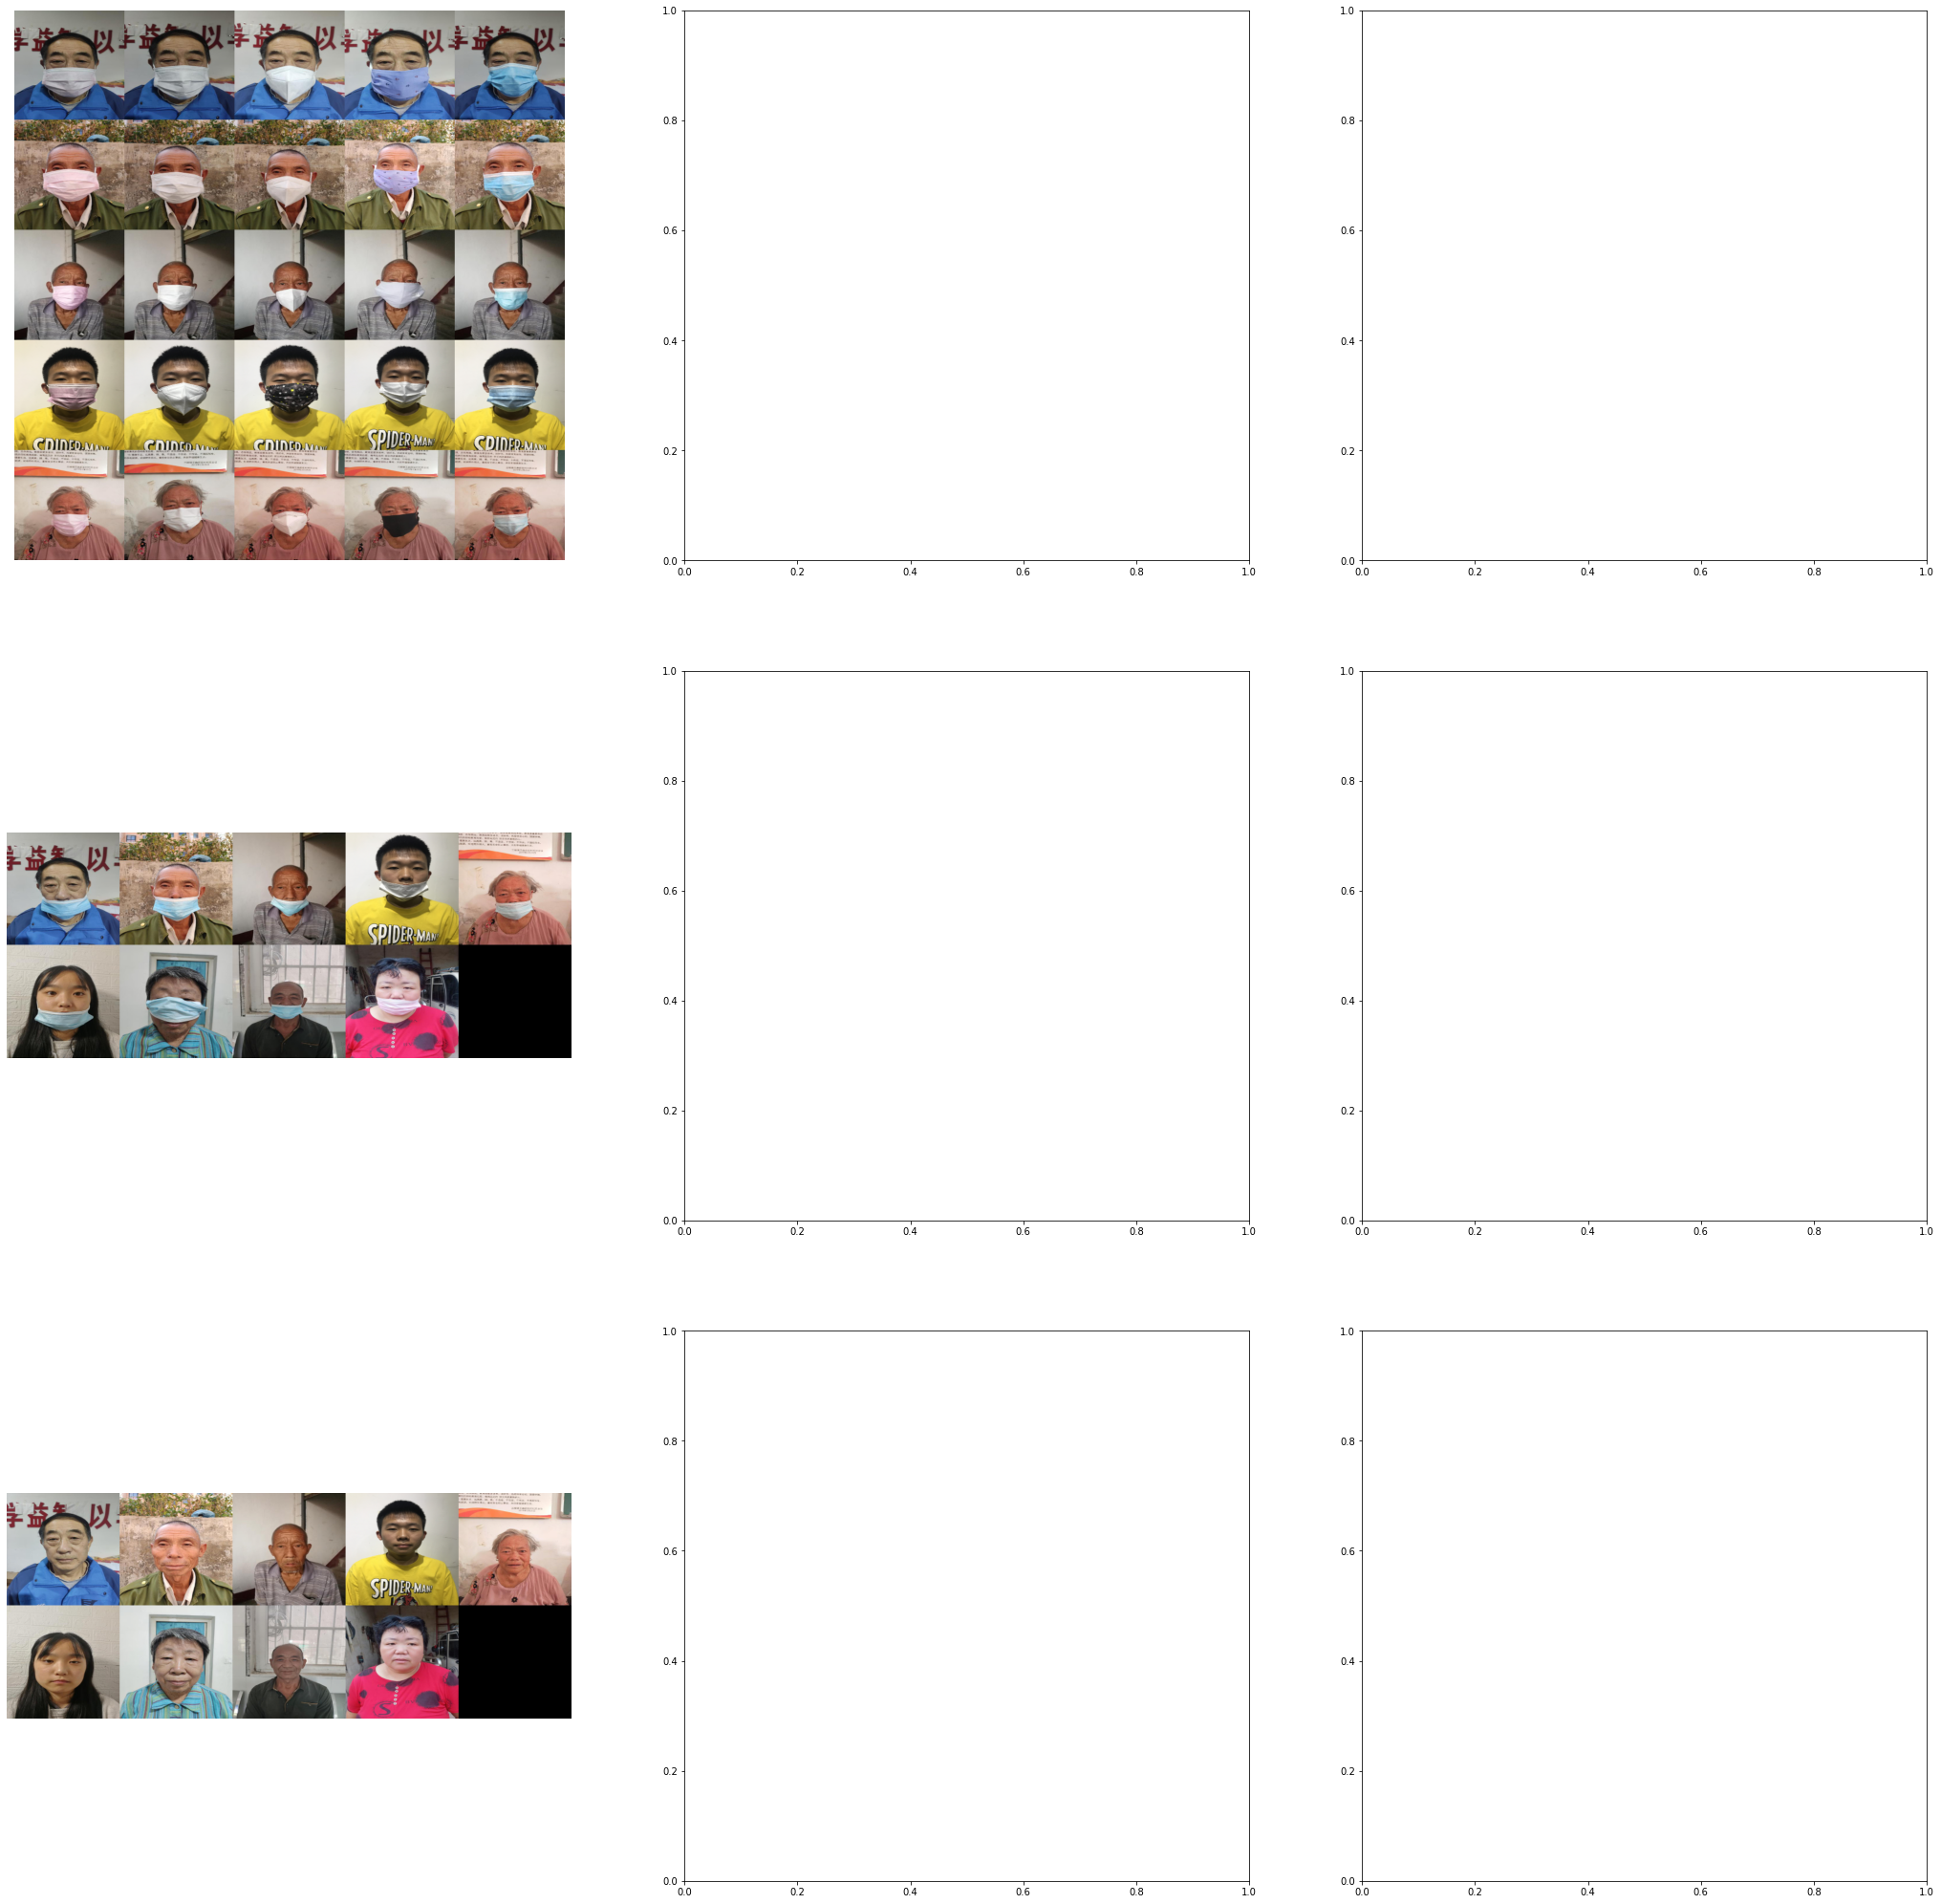

In [42]:
from itertools import product

fig, axes = plt.figure(figsize=(36, 36))

for idx, (label_idx, pred_idx) in enumerate(product(range(3), range(3))):
    conf_images = images[(labels == label_idx) & (outputs == pred_idx)]
    plt.subplot(3, 3, idx + 1)
    try:
        plot_peoples(conf_images[:25], images_per_row=5)
    except Exception as e:
        print(e)

## Predict.py 체크

In [ ]:
import os

os.chdir('/opt/ml/P-Stage/1-STAGE/')

from config import get_args
from prepare import get_dataloader, get_transforms

args = get_args()
args.device = "cuda:0" if torch.cuda.is_available() else "cpu"
args.test = False
